In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATACseq_250kb_bins.txt', 'data/all_samples_normalized_gaussian_smooth_CONTROLS.csv', 'data/all_samples_normalized_gaussian_smooth_CASES.csv', "input_atac" = 'data/ATACseq_250kb_bins.txt', "input_train_data_std" = 'data/all_samples_normalized_gaussian_smooth_CONTROLS.csv', "input_test_data_std" = 'data/all_samples_normalized_gaussian_smooth_CASES.csv'),
    output = list('data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_gaussian.csv', 'Trained_models/On_all_individuals/Lasso_models/lasso_std_TRUE_gaussian.rds', "output_pred" = 'data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_gaussian.csv', "output_model" = 'Trained_models/On_all_individuals/Lasso_models/lasso_std_TRUE_gaussian.rds'),
    params = list(),
    wildcards = list('TRUE', "std" = 'TRUE'),
    threads = 4,
    log = list('logs/processed_notebooks/processed_all_samples_Smooth_gaussian_10_Lasso_reg_TRUE.r.ipynb', "notebook" = 'logs/processed_notebooks/processed_all_samples_Smooth_gaussian_10_Lasso_reg_TRUE.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 71800, "tmpdir" = '/scratch/55859186', "time" = '12:00:00'),
    config = list(),
    rule = 'all_samples_model_lasso_standardizing',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Train_all_samples_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression on data smoothed with Gaussian (n = 10)

In [2]:
library(tidyverse)

library(glmnet)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_CONTROLS.csv", nrows=50000)
all_samples_gaussian_controls <- read.csv(snakemake@input[["input_train_data_std"]])

In [4]:
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_gaussian_controls <- inner_join(all_samples_gaussian_controls, ATAC, by="bin")

head(all_samples_ATAC_gaussian_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,ATAC_observed
PGDX16568P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5866651
PGDX16568P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.1996134
PGDX16568P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5968816
PGDX16568P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2905764
PGDX16568P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2319729
PGDX16568P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_gaussian_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_gaussian_controls %>% select(sample, bin)
all_samples_ATAC_gaussian_controls = all_samples_ATAC_gaussian_controls %>% select(-c(ATAC_observed, sample, bin))

## Finding the best lambda

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

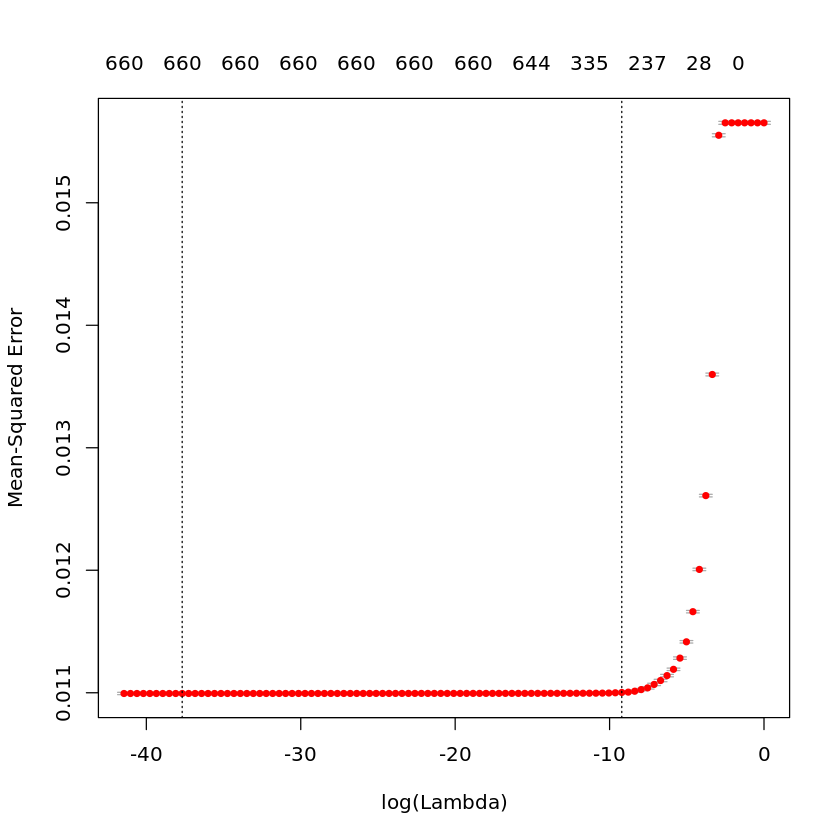

In [6]:
set.seed(0)
#X==predictor
#y==response
#sum_control_ATAC_bin_rm <- sum_control_ATAC  %>% dplyr::select(-bin)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
#head(X)

lambdas_to_try <- 10^seq(-18, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0

lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [7]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 4.328761e-17

In [8]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    
    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    #se    <- (observed-predicted)^2
    #mse   <- mean(se)
    #(rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [9]:
(res_lasso_gaussian_pred_controls <- CV_lasso_smooth(all_samples_ATAC_gaussian_controls, 10))

observed,predicted
0.5866651,0.4406777
0.1996134,0.3505540
0.5968816,0.4436043
0.2905764,0.3507151
0.2319729,0.3723988
0.2262170,0.3697593
0.3546569,0.4091363
0.4456518,0.4456799
0.4719340,0.4539824
0.4991555,0.4289218


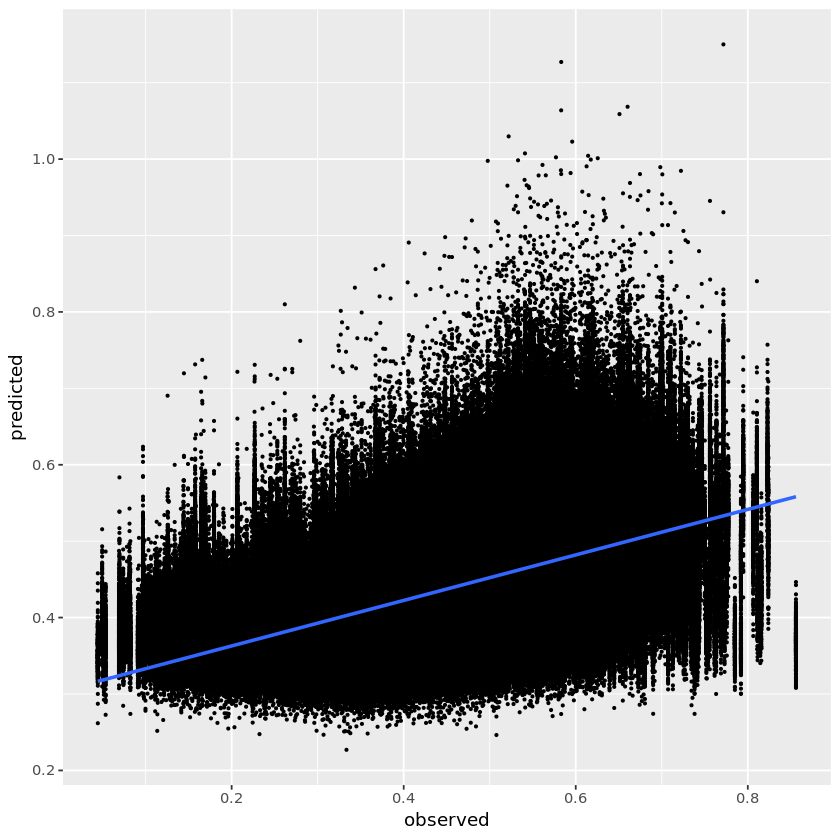

In [10]:
ggplot(res_lasso_gaussian_pred_controls, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [11]:
cor(res_lasso_gaussian_pred_controls$observed, res_lasso_gaussian_pred_controls$predicted)

# Standardize = TRUE: ATAC_val 0.6947938s
# Standardize = FALSE: ATAC_val 0.6962595

ATAC_observed,0.5454222


## Save the predictions made with CV on controls to file

In [12]:
res_lasso_gaussian_pred_controls <- controls_predictions %>% mutate(ATAC_observed = res_lasso_gaussian_pred_controls$observed, 
                                                                    ATAC_predicted = res_lasso_gaussian_pred_controls$predicted)

head(res_lasso_gaussian_pred_controls)

sample,bin,ATAC_observed,ATAC_predicted
PGDX16568P,chr10_400,0.5866651,0.4406777
PGDX16568P,chr10_40,0.1996134,0.3505540
PGDX16568P,chr10_4,0.5968816,0.4436043
PGDX16568P,chr10_401,0.2905764,0.3507151
PGDX16568P,chr10_402,0.2319729,0.3723988
PGDX16568P,chr10_403,0.2262170,0.3697593


In [13]:
write.table(res_lasso_gaussian_pred_controls, snakemake@output[["output_pred"]], append = F, sep=',', col.names=T, row.names=F)

In [14]:
rm(controls_predictions)

## Fit the model on all controls

In [15]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


rm(X)
rm(y)
#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)

## Predict on normalized smoothed cases using the model (fitted on all controls) and add the predictions to the file

In [16]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_CASES.csv"
filename = snakemake@input[["input_test_data_std"]]

In [17]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)


Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX10344P1,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
rm(small_test)

In [19]:
f <- function(df1, pos) {
    df1[3:673] <- lapply(df1[3:673], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    pred_tibble <- tibble(sample = df1$sample, bin = df1$bin)
    rm(df)
    rm(df1)
    pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
    pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)
    
    rm(tmp)
    #message(pred_tibble)
    write.table(pred_tibble, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)

}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())


Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
